<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the Data</a></span></li><li><span><a href="#Summarize" data-toc-modified-id="Summarize-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Summarize</a></span></li><li><span><a href="#Simple-Models" data-toc-modified-id="Simple-Models-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Simple Models</a></span></li></ul></li><li><span><a href="#Soft-PLS-DA-Model-for-Species" data-toc-modified-id="Soft-PLS-DA-Model-for-Species-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Soft PLS-DA Model for Species</a></span><ul class="toc-item"><li><span><a href="#Optimize-a-Model" data-toc-modified-id="Optimize-a-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Optimize a Model</a></span></li><li><span><a href="#SHAP-Explanations" data-toc-modified-id="SHAP-Explanations-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SHAP Explanations</a></span></li><li><span><a href="#Look-at-mistakes" data-toc-modified-id="Look-at-mistakes-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Look at mistakes</a></span></li></ul></li><li><span><a href="#SIMCA-Model-for-Species" data-toc-modified-id="SIMCA-Model-for-Species-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SIMCA Model for Species</a></span><ul class="toc-item"><li><span><a href="#Optimize-Models" data-toc-modified-id="Optimize-Models-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Optimize Models</a></span></li><li><span><a href="#SHAP-Explanations" data-toc-modified-id="SHAP-Explanations-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>SHAP Explanations</a></span></li><li><span><a href="#Examine-Errors" data-toc-modified-id="Examine-Errors-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Examine Errors</a></span></li></ul></li><li><span><a href="#SIMCA-Model-for-Murre-Colony" data-toc-modified-id="SIMCA-Model-for-Murre-Colony-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SIMCA Model for Murre Colony</a></span><ul class="toc-item"><li><span><a href="#Select-Data" data-toc-modified-id="Select-Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Select Data</a></span></li><li><span><a href="#Optimize-Models" data-toc-modified-id="Optimize-Models-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Optimize Models</a></span></li></ul></li><li><span><a href="#PLS-DA-Model-for-Murre-Colony" data-toc-modified-id="PLS-DA-Model-for-Murre-Colony-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PLS-DA Model for Murre Colony</a></span></li></ul></div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/chemometrics.git
    !cd chemometrics; pip3 install -r requirements.txt
else:
    import sys
    sys.path.append('../../../')

import chemometrics
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import imblearn
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

shap.initjs()

Overview
--------
This notebook illustrates some chemometric analysis of anthropogenic pollutants found in seabirds in the North Pacific from the STAMP database.

For more analysis, see this [repo](https://github.com/mahynski/stamp-dataset-1999-2010) and associated publications:
* Mahynski NA, Ragland JM, Schuur SS, Pugh R, Shen VK, "Seabird Tissue Archival and Monitoring Project (STAMP) Data from 1999-2010," Journal of Research of the National Institute of Standards and Technology, Volume 126, Article No. 126028, https://dx.doi.org/10.6028/jres.126.028

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.31.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 4.15.0-169-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

watermark : 2.3.0
json      : 2.0.9
imblearn  : 0.9.0
shap      : 0.40.0
sys       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
seaborn   : 0.11.2
matplotlib: 3.5.1
pandas    : 1.3.5
numpy     : 1.21.5
sklearn   : 0.0



# Exploratory Data Analysis

## Load the Data

In [4]:
X_raw = pd.read_csv('https://raw.githubusercontent.com/mahynski/stamp-dataset-1999-2010/master/X.csv')
y_raw = pd.read_csv('https://raw.githubusercontent.com/mahynski/stamp-dataset-1999-2010/master/y.csv')
df_raw = pd.concat((y_raw, X_raw), axis=1, join='outer', ignore_index=False)

In [5]:
df_raw.head()

,COLLECTION_YEAR,COLONY_NAME,COMMON_NAME,GUSAMPLEID,"2,4' DDD","2,4' DDE","4,4' DDD and 2,4' DDT","4,4' DDE","4,4' DDT",HCB,...,PCBs 28 and 31,a-HCH,cis-chlordane,cis-nonachlor,g-HCH,mirex,oxychlordane,total mercury,trans-chlordane,trans-nonachlor
0,2001.0,St. Lazaria Isl.,Common murre,ACU102367,0.046087,0.266,0.127432,412.0,0.037299,35.3,...,3.99,1.130,0.007855,1.220,0.276,2.84,10.20,0.1409,0.054008,0.206
1,2001.0,St. Lazaria Isl.,Common murre,ACU102368,0.050111,0.255,0.101151,194.0,0.041345,32.3,...,1.92,0.909,0.052286,0.400,0.290,1.45,5.26,0.1787,0.022724,0.168
2,2001.0,St. Lazaria Isl.,Common murre,ACU102369,0.044125,0.284,1.576000,173.0,0.087000,27.0,...,2.57,0.947,0.458000,8.820,0.227,1.97,7.51,0.1596,0.435000,3.110
3,2001.0,St. Lazaria Isl.,Common murre,ACU102370,0.066260,0.264,1.190000,197.0,0.009136,31.4,...,2.13,1.160,0.016975,0.503,0.306,1.66,5.94,0.1140,0.046001,0.177
4,2001.0,St. Lazaria Isl.,Common murre,ACU102371,0.046355,0.177,0.066805,266.0,0.007308,24.9,...,2.26,1.330,0.018454,1.340,0.453,2.76,7.41,0.1984,0.054451,0.257


## Summarize

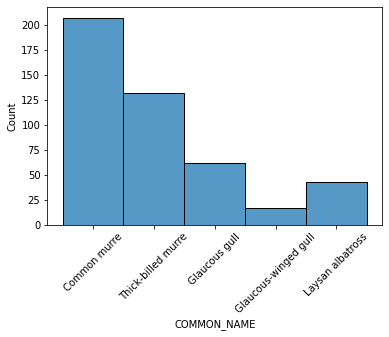

In [6]:
sns.histplot(df_raw, x='COMMON_NAME')
_ = plt.xticks(rotation=45)

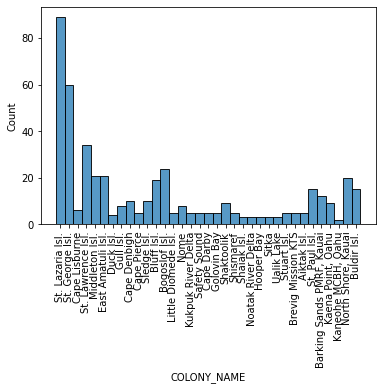

In [7]:
sns.histplot(df_raw, x='COLONY_NAME')
_ = plt.xticks(rotation=90)

## Simple Models

Text(0.5, 1.0, 'LDA')

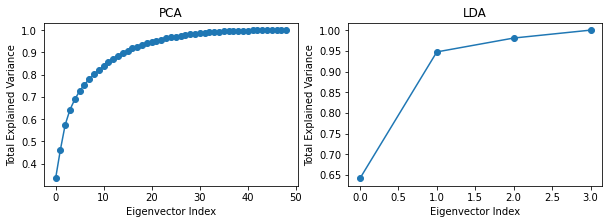

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA as PCA
from sklearn.preprocessing import StandardScaler

lda = LDA(solver='svd', shrinkage=None, n_components=4)
pca = PCA(whiten=False, random_state=0)

ss = StandardScaler()
X_scaled = ss.fit_transform(X_raw)

lda.fit(X_scaled, df_raw['COMMON_NAME'])
pca.fit(X_scaled)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax = axes.flatten()

ax[0].plot(np.cumsum(pca.explained_variance_ratio_), '-o')
ax[0].set_ylabel('Total Explained Variance')
ax[0].set_xlabel('Eigenvector Index')
ax[0].set_title('PCA')

ax[1].plot(np.cumsum(lda.explained_variance_ratio_), '-o')
ax[1].set_ylabel('Total Explained Variance')
ax[1].set_xlabel('Eigenvector Index')
ax[1].set_title('LDA')

In [9]:
%matplotlib notebook

<IPython.core.display.Javascript object>


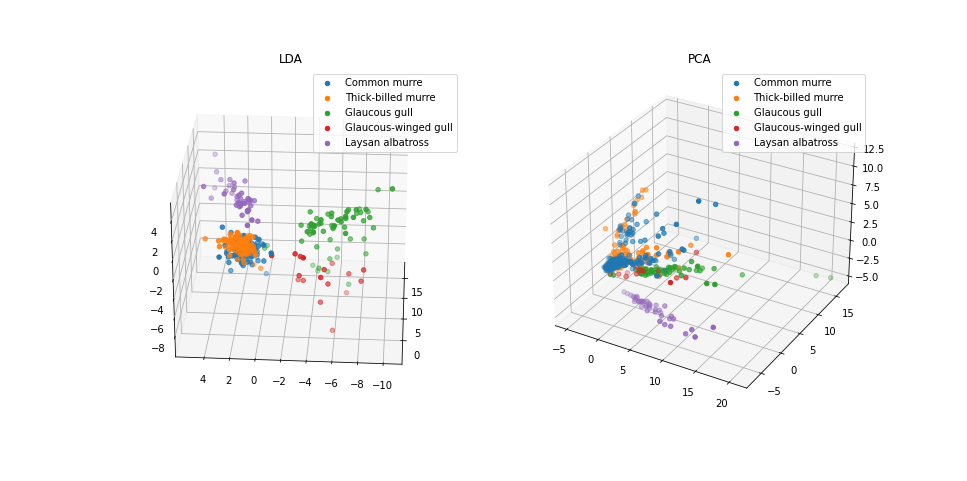

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

X_new_lda = lda.transform(X_scaled)
X_new_pca = pca.transform(X_scaled)

ax = fig.add_subplot(121, projection='3d')
ax.set_title('LDA')
for species in df_raw.COMMON_NAME.unique():
    x_ = X_new_lda[df_raw['COMMON_NAME'].values == species,:]
    ax.scatter(x_[:,0], x_[:,1], x_[:,2], label=species)
plt.legend(loc='best')

ax = fig.add_subplot(122, projection='3d')
ax.set_title('PCA')
for species in df_raw.COMMON_NAME.unique():
    x_ = X_new_pca[df_raw['COMMON_NAME'].values == species,:]
    ax.scatter(x_[:,0], x_[:,1], x_[:,2], label=species)
plt.legend(loc='best')

In [11]:
# LDA does a pretty good job separating based on species (common name). As found in previous work, the murre
# species are basically indistinguishable.

In [12]:
y_merged_murre = y_raw['COMMON_NAME'].apply(lambda x: x if 'murre' not in x else 'Murre')

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, 
    y_merged_murre, 
    test_size=0.2, 
    random_state=0, 
    stratify=y_merged_murre
)

# Soft PLS-DA Model for Species

In [52]:
# It is interesting to start with a discrimination model for species so we can compare an authentication
# model (SIMCA) to it later.

In [53]:
from chemometrics.classifier.plsda import PLSDA

## Optimize a Model

In [54]:
# Let's optimize a PLS-DA model based on its total efficiency (TEFF). Data scaling is handled
# internally via the scale_x hyperparameter so we don't need additional step initially, unless
# you want to add this for some reason.

pipeline = imblearn.pipeline.Pipeline(steps=[
    # Insert other preprocessing steps here...
    ("plsda", PLSDA(n_components=3, 
                    alpha=0.05,
                    gamma=0.01,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='soft', 
                    score_metric='TEFF'
                   )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    'plsda__n_components':np.arange(3, 20, 2),
    'plsda__alpha': [0.05], 
    'plsda__scale_x': [True], # SITE data makes sense to standardize
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=3, 
        shuffle=True, 
        random_state=0,
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [55]:
gs.best_score_

0.8750461832469808

In [56]:
gs.best_params_

{'plsda__alpha': 0.05, 'plsda__n_components': 9, 'plsda__scale_x': True}

In [57]:
pred = gs.predict(X_test)
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(pred, y_test)

In [58]:
df 

# The primary confusion is between gull species - if they had been merged like the Murre, performance 
# would likely be better. Note that some murre are considered unknown!

,Glaucous gull,Glaucous-winged gull,Laysan albatross,Murre,UNKNOWN
Glaucous gull,11,10,0,0,0
Glaucous-winged gull,2,3,0,0,0
Laysan albatross,0,0,8,0,1
Murre,1,3,0,60,7


In [61]:
%matplotlib notebook

<IPython.core.display.Javascript object>


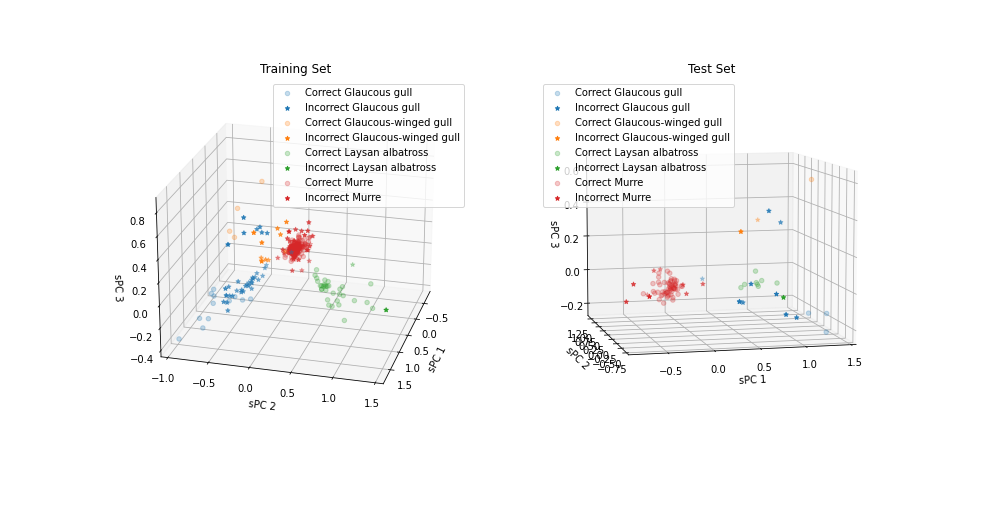

In [62]:
# Let's visualize the results
fig = plt.figure()
for i, (x_, y_, title) in enumerate(zip( (X_train, X_test), (y_train, y_test), ('Training Set', 'Test Set') )):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    for j, class_ in enumerate(np.unique(y_)):
        mask = y_ == class_
        
        correct = np.array([a==b for a,b in zip([[a] for a in y_[mask].tolist()], gs.predict(x_[mask]))])
        
        X_proj = gs.transform(x_[mask])
        if np.sum(correct > 0):
            ax.scatter(X_proj[correct,0], X_proj[correct,1], X_proj[correct,2], 
                       label='Correct '+class_, color='C{}'.format(j), marker='o', alpha=0.25)
        if np.sum(~correct > 0):
            ax.scatter(X_proj[~correct,0], X_proj[~correct,1], X_proj[~correct,2], 
                       label='Incorrect '+class_, color='C{}'.format(j), marker='*')

    ax.set_xlabel('sPC 1')
    ax.set_ylabel('sPC 2')
    ax.set_zlabel('sPC 3')
    ax.legend(loc='best')
    ax.set_title(title)

## SHAP Explanations

In [28]:
fast = False 

# If we run a "fast" analysis of this data, we see very similar results for the top analytes, etc.
# However, one shortcoming is the absence of mirex anywhere in the explanation (top 10 analytes anyway),
# which is one of the leading features in decision trees trained to discriminate between these species/genera.
# Different models are not necessarily expected to use the same information the same way (this is the point
# of using ensembles of different classifiers), but the absence of mirex is strange.  

# If you run the longer analysis (using the full training set as background, etc.) you see mirex enter the
# top 10 most important features.  It is not near the top (relatively unchanged), but this does serve to 
# illustrate the effects that approximations for the sake of speed can have on SHAP values.

if fast:
    # Do a fast explanation
    explainer = shap.KernelExplainer(
        model = gs.predict_proba, 
        data = shap.sample(X_train, 10, random_state=0), 
    )
    
    shap_values_train = explainer.shap_values(X_train, 
                                        nsamples='auto', # Can increase for lower variance
                                        l1_reg='num_features({})'.format(
                                            np.min(
                                                [X_train.shape[1], 20] # Only look at (up to) the top 20 features
                                            )
                                        )
                                       )  
    
    shap_values_test = explainer.shap_values(X_test, 
                                        nsamples='auto', # Can increase for lower variance
                                        l1_reg='num_features({})'.format(
                                            np.min(
                                                [X_test.shape[1], 20] # Only look at (up to) the top 20 features
                                            )
                                        )
                                       )
else:
    try:
        # Load if already saved
        with open('shap_values_train.plsda.slow', 'rb') as f:
            shap_values_train = pickle.load(f)
        with open('shap_values_test.plsda.slow', 'rb') as f:
            shap_values_test = pickle.load(f)
            
        explainer = shap.KernelExplainer(
            model = gs.predict_proba, 
            data = X_train, 
        )
    except:
        # Do a slow, more complete calculation
        explainer = shap.KernelExplainer(
            model = gs.predict_proba, 
            data = X_train, 
        )
        print(explainer.expected_value)

        shap_values_train = explainer.shap_values(X_train, 
                                            nsamples='auto', # Can increase for lower variance
                                           )  

        shap_values_test = explainer.shap_values(X_test, 
                                            nsamples='auto', # Can increase for lower variance
                                           )
        import pickle
        pickle.dump(shap_values_train, open('shap_values_train.plsda.slow', 'wb'))
        pickle.dump(shap_values_test, open('shap_values_test.plsda.slow', 'wb'))

Using 368 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [22]:
fig = plt.figure(figsize=(10,6))

for chosen_class in [0, 1, 2, 3]:
    ax = fig.add_subplot(2, 2, chosen_class+1)
    ax.set_title(gs.best_estimator_.named_steps['plsda'].categories[chosen_class])
    sv = shap_values_train[chosen_class]

    shap.summary_plot(
        shap_values=sv,
        features=X_train,
        feature_names=X_raw.columns,
        plot_type='violin',
        max_display=10
    )
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


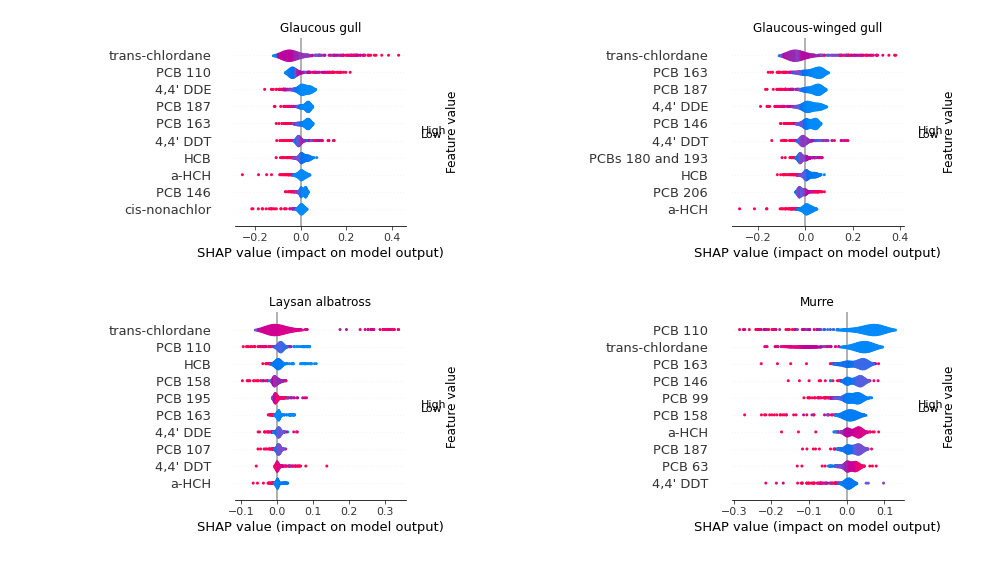

In [64]:
# fig = plt.figure(figsize=(10,6))

# for chosen_class in [0, 1, 2, 3]:
#     ax = fig.add_subplot(2, 2, chosen_class+1)
#     ax.set_title(gs.best_estimator_.named_steps['plsda'].categories[chosen_class])
#     sv = shap_values_train[chosen_class]

#     shap.summary_plot(
#         shap_values=sv,
#         features=X_train,
#         feature_names=X_raw.columns,
#         plot_type='violin',
#         max_display=10
#     )
# plt.tight_layout()

In [23]:
fig = plt.figure(figsize=(10,6))

for chosen_class in [0, 1, 2, 3]:
    ax = fig.add_subplot(2, 2, chosen_class+1)
    ax.set_title(gs.best_estimator_.named_steps['plsda'].categories[chosen_class])
    sv = shap_values_test[chosen_class]

    shap.summary_plot(
        shap_values=sv,
        features=X_test,
        feature_names=X_raw.columns,
        plot_type='violin',
        max_display=10
    )
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


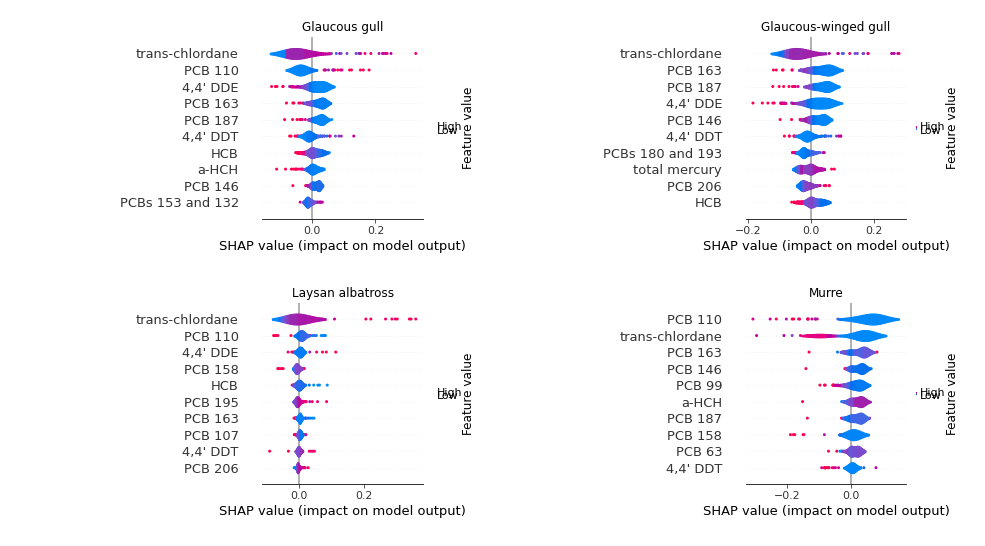

In [65]:
# fig = plt.figure(figsize=(10,6))

# for chosen_class in [0, 1, 2, 3]:
#     ax = fig.add_subplot(2, 2, chosen_class+1)
#     ax.set_title(gs.best_estimator_.named_steps['plsda'].categories[chosen_class])
#     sv = shap_values_test[chosen_class]

#     shap.summary_plot(
#         shap_values=sv,
#         features=X_test,
#         feature_names=X_raw.columns,
#         plot_type='violin',
#         max_display=10
#     )
# plt.tight_layout()

In [ ]:
# In the 'FAST' SHAP analysis:
# Notably, mirex is NOT showing up here for the albatross, which is a very good discriminator as seen in 
# previous studies. (mirex is a pesticide used to protect pineapple crops - this is used in Hawaii, not Alaska
# where all the albatross samples in this dataset come from).

# In the 'SLOW' SHAP analysis:
# Mirex/HCB show up prominently.

# Regardless, trans-chlordane and PCB 110 are playing important roles here.  This was seen in previous studies
# using other discrimination models (see publication(s)).  PLS-DA is also a discrimination model, even if we 
# are using a 'soft' decision boundary, so this is consistent with previous results, although PLS-DA numerically
# under-performs decision trees, for example, in those studies (~87% TEFF vs. > 95% accuracy).  It is important 
# to remember, though, that this 'soft' modeling can predict a sample belongs to None of the previously seen
# classes, whereas decision trees, for example, cannot.

## Look at mistakes

In [63]:
def examine_mistakes(predicted_class, actual_class, y_, X_, shap_values):
    pred_idx = np.argmax(gs.best_estimator_.named_steps['plsda'].categories == predicted_class)
    
    # Here we will consider a prediction a "mistake" if the true class is not at all among the 
    # class(es) a point is classified as.
    mask = y_.values == actual_class
    incorrect = ~np.array([a in b for a,b in zip(y_.values[mask].tolist(), gs.predict(X_[mask]))])

    plt.figure()
    plt.title('Prob({} | {}) Set'.format(predicted_class, actual_class))
    shap.decision_plot(
        explainer.expected_value[pred_idx], 
        shap_values[pred_idx][mask], 
        feature_names=X_raw.columns.tolist(),
        highlight=incorrect,
    )

    return np.array(gs.predict(X_[mask]), dtype=object)[incorrect]

In [64]:
df

,Glaucous gull,Glaucous-winged gull,Laysan albatross,Murre,UNKNOWN
Glaucous gull,11,10,0,0,0
Glaucous-winged gull,2,3,0,0,0
Laysan albatross,0,0,8,0,1
Murre,1,3,0,60,7


<IPython.core.display.Javascript object>


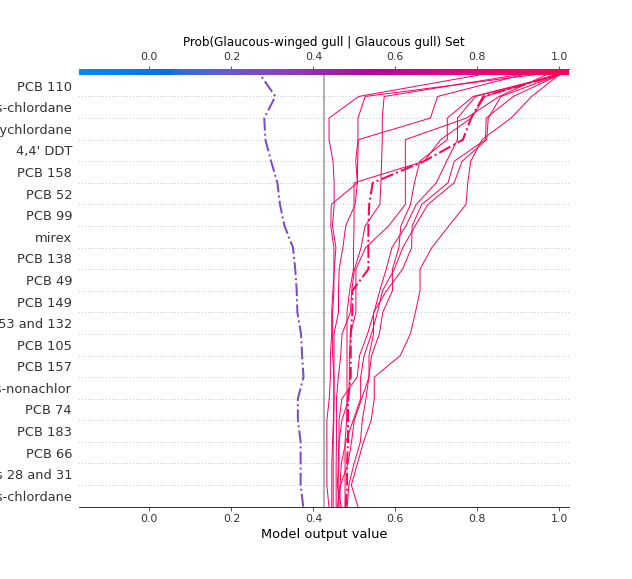

In [65]:
# Clearly, MOST GG ARE predicted (>50%) to be GWG (also). So this model is obviously not
# very specific.  This can clearly be inferred from the first row of the data table above.

# Also, the 2 "mistakes" here (no GG in classes predicted) clearly ARE predicted to atleast be GWG.
# That is somewhat heartening since the model at least thinks they are gulls, even if it is the 
# wrong one.
total_mistakes = examine_mistakes(predicted_class = 'Glaucous-winged gull',
                            actual_class = 'Glaucous gull',
                            y_ = y_test,
                            X_ = X_test,
                            shap_values=shap_values_test
                           )

In [66]:
# The mistakes were considered EXCLUSIVELY GWG instead of GG - not bad since they are known to be similar.
# Interestingly, the mistakes seem to be in the "middle of the pack" above.  Taken together, this suggests
# that the model really cannot tell GWG from GG very well at all - though clearly it is not getting 
# confused with respect to the other (see table above).
total_mistakes

array([list(['Glaucous-winged gull']), list(['Glaucous-winged gull'])],
      dtype=object)

<IPython.core.display.Javascript object>


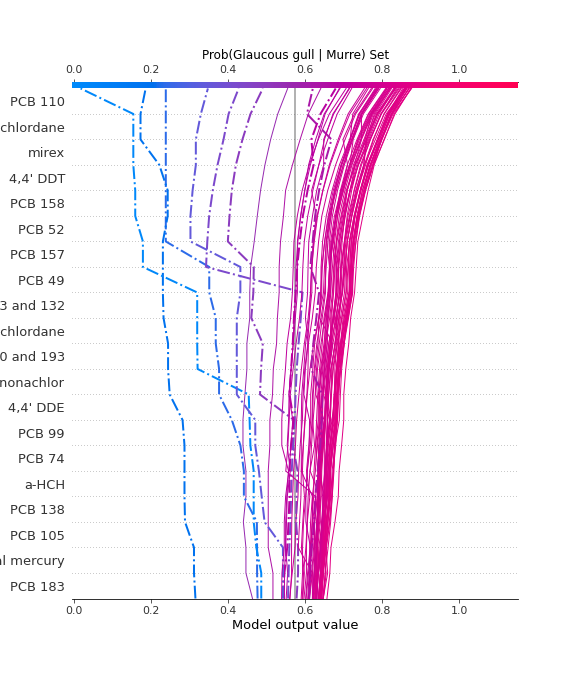

In [67]:
# Only 1 incorrect prediction which seems linked to chlordane again.

# Is this real, or a bad measurement? Hypothesese like this can be generated from decision plots.

# The other paths highlighted are the "unknowns" and GWG
total_mistakes = examine_mistakes(predicted_class = 'Glaucous gull',
                                  actual_class = 'Murre',
                                  y_ = y_test,
                                  X_ = X_test,
                                  shap_values=shap_values_test
                )

In [68]:
# With one exception, most murre were clearly not predicted to be GG.  Note that PCB 110 and trans-chlordane
# were clearly very important players in that (correct) decision making process as evidence by the the 
# severe "left turn" the decision paths take at the top!

# Interestingly, the one murre that was wrongly predicted to be in the GG class had that decision made based
# on the trans-chlordane level in that sample.

# Most "mistakes" for the murre turn out to be "unknown".
total_mistakes

array([list(['UNKNOWN']), list(['UNKNOWN']), list(['UNKNOWN']),
       list(['UNKNOWN']), list(['UNKNOWN']), list(['UNKNOWN']),
       list(['UNKNOWN']), list(['Glaucous-winged gull', 'Glaucous gull'])],
      dtype=object)

<IPython.core.display.Javascript object>


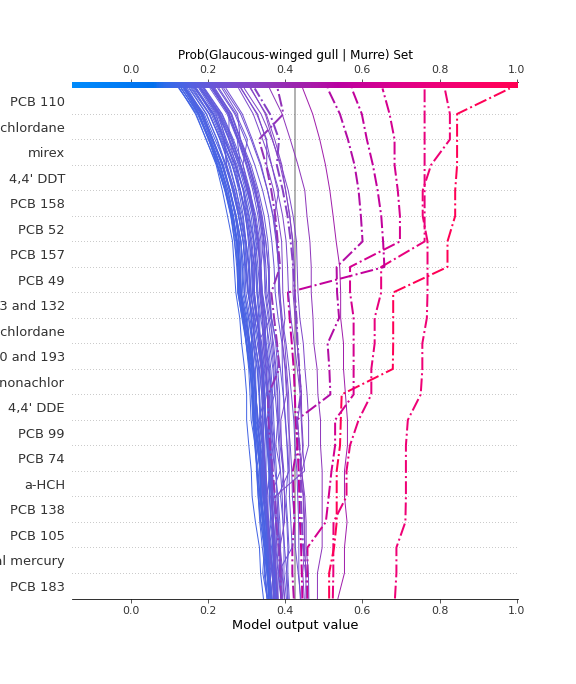

In [69]:
total_mistakes = examine_mistakes(predicted_class = 'Glaucous-winged gull',
                 actual_class = 'Murre',
                 y_ = y_test,
                 X_ = X_test,
                 shap_values=shap_values_test
                )

In [167]:
# A similar story unfolds for murre predicted to be GWG, which is unsurprising because GWG and GG have, so far,
# clearly been similar otherwise.

# SIMCA Model for Species

In [15]:
# Let's build a SIMCA authentication/classification model for each species

In [16]:
from chemometrics.classifier.simca import SIMCA_Classifier

## Optimize Models

In [17]:
models = {}
targets = sorted(np.unique(y_train))

for target in targets:
    pipeline = imblearn.pipeline.Pipeline(steps=[
        ("simca", SIMCA_Classifier(n_components=7, 
                                   alpha=0.05, 
                                   scale_x=True, 
                                   style='dd-simca', 
                                   target_class=target, 
                                   use='TEFF')
        )
    ])

    # Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
    n_splits = 10
    max_dim = np.min([20, int(np.sum(y_train.values == target)*(n_splits-1.0)/n_splits) - 1])
    param_grid = [{
        'simca__n_components':np.arange(1, max_dim),
        'simca__alpha':[0.05],
        'simca__style':['dd-simca'],
        'simca__scale_x':[True]
    }]

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.StratifiedKFold(
            n_splits=n_splits, 
            shuffle=True, 
            random_state=0
        ),
        error_score=0,
        refit=True
    )

    _ = gs.fit(X_train, y_train)
    
    models[target] = gs
    
    print(target, gs.best_params_, max_dim)

Glaucous gull {'simca__alpha': 0.05, 'simca__n_components': 7, 'simca__scale_x': True, 'simca__style': 'dd-simca'} 20
Glaucous-winged gull {'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': True, 'simca__style': 'dd-simca'} 11
Laysan albatross {'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': True, 'simca__style': 'dd-simca'} 20
Murre {'simca__alpha': 0.05, 'simca__n_components': 17, 'simca__scale_x': True, 'simca__style': 'dd-simca'} 20


In [18]:
# Observe that GWG has the fewest observations in the dataset so this is why (1) it cannot have as many PCA
# dimensions as others, and (2) authentication models are not likely to fit well because they do not have
# enough examples to learn from.

# Also not that most (except Murre) are in very low dimensional space! This could be due to the fact that
# there are a lot of Murre samples which might be very diverse.

In [19]:
# SIMCA performs very well on test set (even better than PLSDA!) except for GWG, unsurprisingly.
for target in models:
    print('Best SIMCA model for {} has TEFF (train) = {}, TEFF (test) = {}'.format(
        target,
        '%.4f'%models[target].score(X_train, y_train),
        '%.4f'%models[target].score(X_test, y_test))
    )

Best SIMCA model for Glaucous gull has TEFF (train) = 0.9143, TEFF (test) = 0.9487
Best SIMCA model for Glaucous-winged gull has TEFF (train) = 0.8636, TEFF (test) = 0.5375
Best SIMCA model for Laysan albatross has TEFF (train) = 0.9701, TEFF (test) = 0.9428
Best SIMCA model for Murre has TEFF (train) = 0.9581, TEFF (test) = 0.9356


<IPython.core.display.Javascript object>


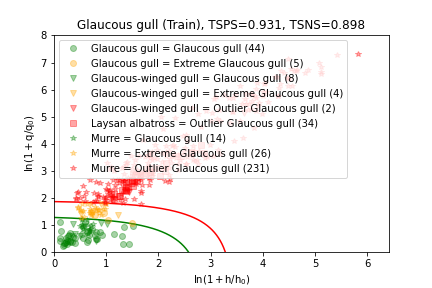

<IPython.core.display.Javascript object>


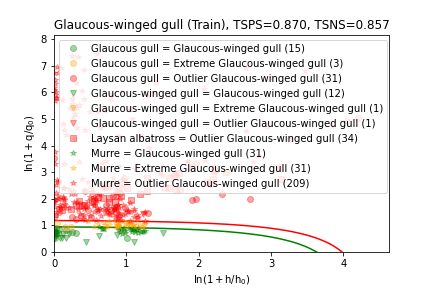

<IPython.core.display.Javascript object>


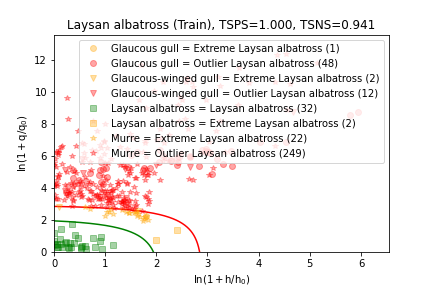

<IPython.core.display.Javascript object>


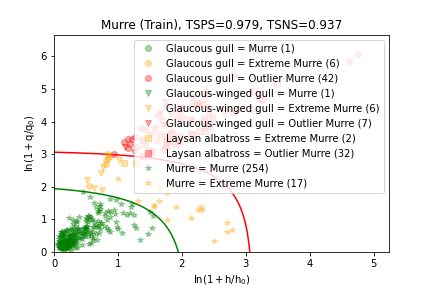

In [20]:
# Everything "fits" well on the training data
for target in targets:
    plt.figure()
    m = models[target].best_estimator_.named_steps['simca']
    m.model.visualize(X_train, y_train, ax=plt.gca())
    m.score(X_train, y_train) # Re-compute score on training set
    plt.gca().legend(loc='best')
    plt.title('{} (Train), TSPS={}, TSNS={}'.format(target, '%.3f'%m.TSPS, '%.3f'%m.TSNS))

<IPython.core.display.Javascript object>


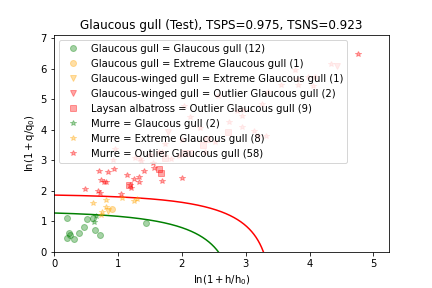

<IPython.core.display.Javascript object>


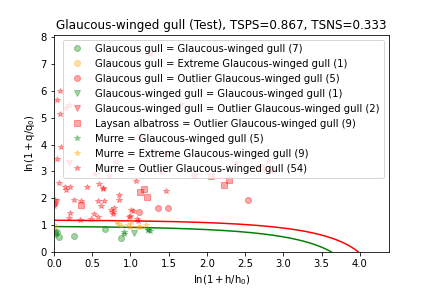

<IPython.core.display.Javascript object>


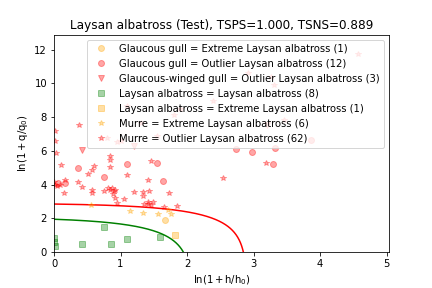

<IPython.core.display.Javascript object>


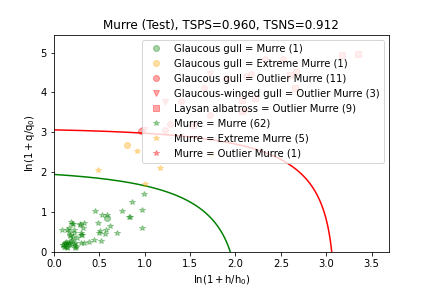

In [21]:
# But GWG doesn't show good results on test set - again this probably just means it needs more data 
# given how little data there is for this class.
for target in targets:
    plt.figure()
    m = models[target].best_estimator_.named_steps['simca']
    m.model.visualize(X_test, y_test, ax=plt.gca())
    m.score(X_test, y_test) # Re-compute score on test set
    plt.gca().legend(loc='best')
    plt.title('{} (Test), TSPS={}, TSNS={}'.format(target, '%.3f'%m.TSPS, '%.3f'%m.TSNS))

In [22]:
# The poor GWG TEFF score is driven by TSNS (~0.3) not TSPS (~0.9).  Only 1 out 3 samples was within the
# boundary, however, this may be due to the "statistics of small numbers" - again, suggesting we need
# more data to fairly assess/train a model for GWG.  Note that the "best" GWG model had only 1 PCA dimension.
# The high TSPS means that atleast SIMCA can recognize foreign classes as foreign(!) it just struggles
# to determine which true classes are actually true.

# Overall, SIMCA performs (in terms of TEFF) about as well as the best discrimination models found in 
# previous work, although soft PLS-DA remarkably under performs!

## SHAP Explanations

In [23]:
fast = False 

shap_results = {}
for target in targets:
    if fast:
        # Do a fast explanation
        explainer = shap.KernelExplainer(
            model = models[target].predict_proba, 
            data = shap.sample(X_train, 10, random_state=0), 
        )

        shap_values_train = explainer.shap_values(X_train, 
                                            nsamples='auto', # Can increase for lower variance
                                            l1_reg='num_features({})'.format(
                                                np.min(
                                                    [X_train.shape[1], 20] # Only look at (up to) the top 20 features
                                                )
                                            )
                                           )  

        shap_values_test = explainer.shap_values(X_test, 
                                            nsamples='auto', # Can increase for lower variance
                                            l1_reg='num_features({})'.format(
                                                np.min(
                                                    [X_test.shape[1], 20] # Only look at (up to) the top 20 features
                                                )
                                            )
                                           )
    else:
        name = '_'.join(target.split(' '))
        try:
            # Load if already saved
            with open('shap_values_train.simca.{}.slow'.format(name), 'rb') as f:
                shap_values_train = pickle.load(f)
            with open('shap_values_test.simca.{}.slow'.format(name), 'rb') as f:
                shap_values_test = pickle.load(f)
        except:
            # Do a slow, more complete calculation
            explainer = shap.KernelExplainer(
                model = models[target].predict_proba, 
                data = X_train, 
            )

            shap_values_train = explainer.shap_values(X_train, 
                                                nsamples='auto', # Can increase for lower variance
                                               )  

            shap_values_test = explainer.shap_values(X_test, 
                                                nsamples='auto', # Can increase for lower variance
                                               )
            import pickle
            pickle.dump(shap_values_train, open('shap_values_train.simca.{}.slow'.format(name), 'wb'))
            pickle.dump(shap_values_test, open('shap_values_test.simca.{}.slow'.format(name), 'wb'))
            
    shap_results[target] = {'Test':shap_values_test, 'Train':shap_values_train}

<IPython.core.display.Javascript object>


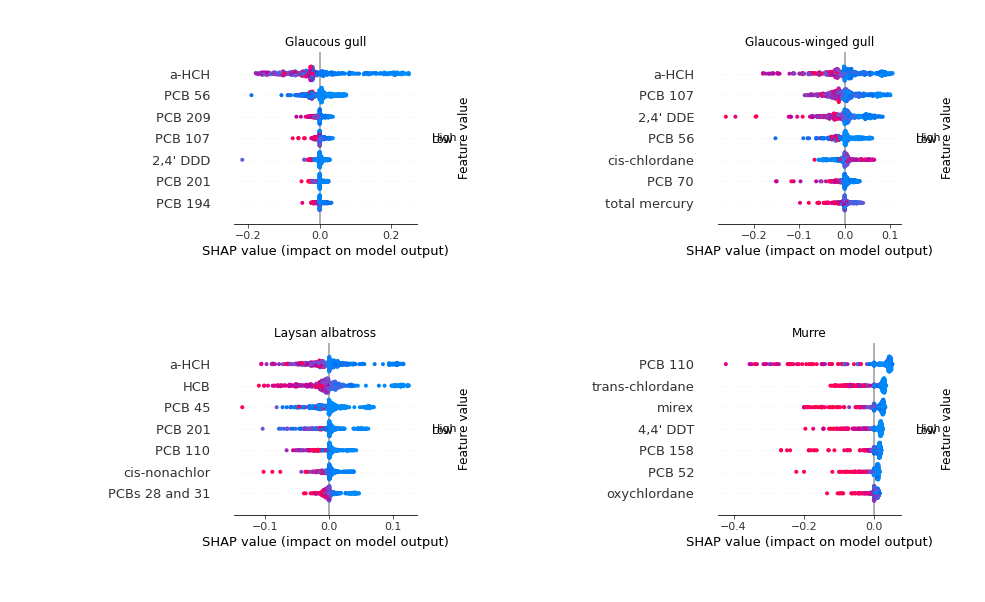

In [24]:
fig = plt.figure(figsize=(10,6))

for chosen_class, target in enumerate(shap_results.keys()):
    ax = fig.add_subplot(2, 2, chosen_class+1)
    ax.set_title(target)

    shap.summary_plot(
        shap_values=shap_results[target]['Train'][0],
        features=X_train,
        feature_names=X_raw.columns,
#         plot_type='violin',
        max_display=7
    )
plt.tight_layout()

<IPython.core.display.Javascript object>


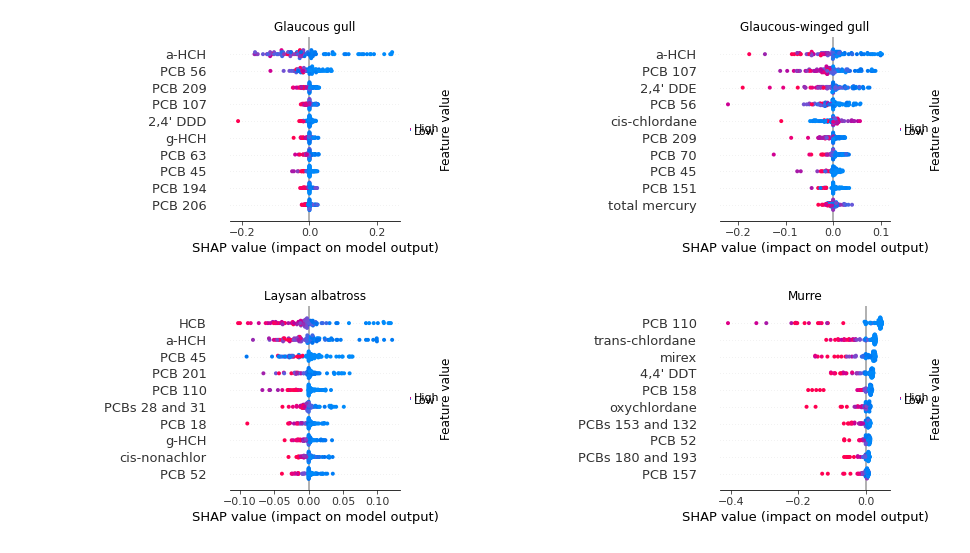

In [25]:
fig = plt.figure(figsize=(10,6))

for chosen_class, target in enumerate(shap_results.keys()):
    ax = fig.add_subplot(2, 2, chosen_class+1)
    ax.set_title(target)

    shap.summary_plot(
        shap_values=shap_results[target]['Test'][0],
        features=X_test,
        feature_names=X_raw.columns,
#         plot_type='violin',
        max_display=10
    )
plt.tight_layout()

In [27]:
# Very similar results for test vs. train.  Interestingly, what this suggests is that low levels of analytes
# seem to be what characterize different classes.  Different classes are characterized by different analytes.
# Note that low HCB instead of high mirex (very closely correlated as per previous publications) distinguishes 
# albatross.

# For PLS-DA and previous work with discrimination models, PCB-110 and trans-chlordane were the most important
# factors in decision making.  Here, with the exception of Murre, these are essentially absent.  This illustrates
# the fundamental differences between discrimination and authentication models. HCB for albatross still present
# which is a surrogate for mirex numerically, at least.

# DMs focus on learning the "boundaries between" classes whereas AMs focus on learning what characterizes
# the positive class.

## Examine Errors

In [28]:
# Still we can examine the errors on the GWG test set for illustration purposes.

true = 'Glaucous-winged gull'

In [31]:
mask = y_test.values == true
print('There are {} samples that are {}'.format(np.sum(mask), true))
print('The prediction for each point is:\n')
for targ in targets:
    print( models[targ].predict(X_test[mask]), targ)

# 1 GWG is correctly predicted True for GWG, but the rest
# of the points are ALL False, so they are basically "unknown".

There are 3 samples that are Glaucous-winged gull
The prediction for each point is:

[False False False] Glaucous gull
[False False  True] Glaucous-winged gull
[False False False] Laysan albatross
[False False False] Murre


Using 368 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


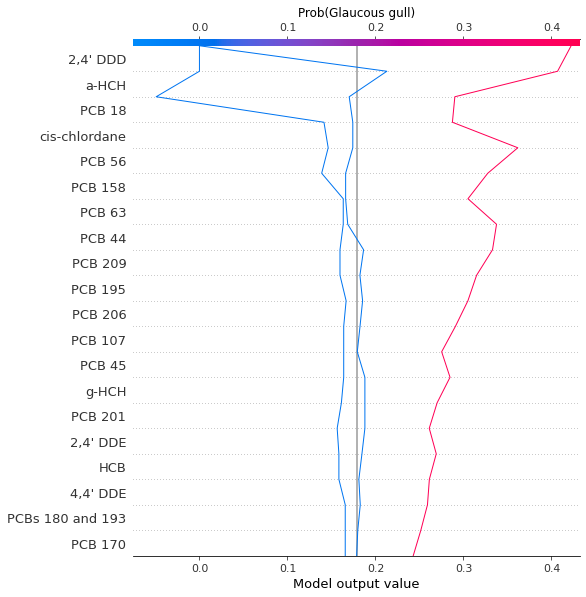

Using 368 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


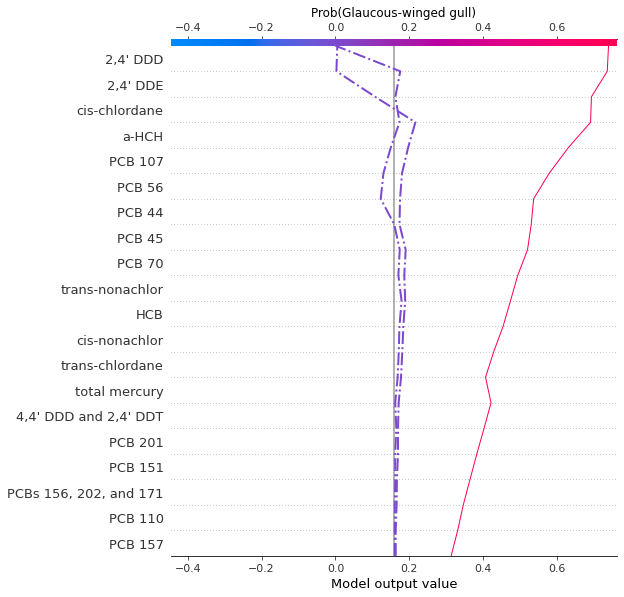

Using 368 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


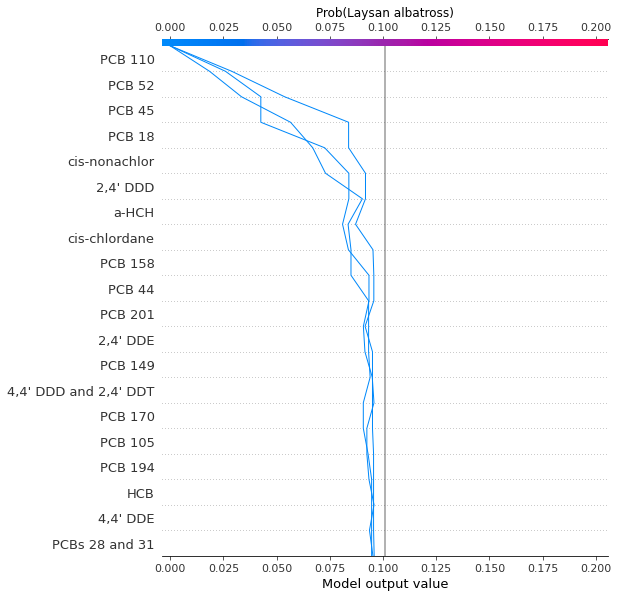

Using 368 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


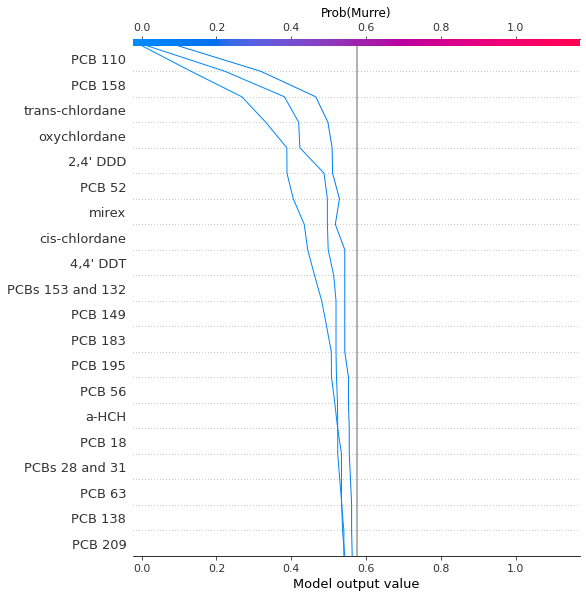

In [51]:
for targ in targets:
    explainer = shap.KernelExplainer(
                        model = models[targ].predict_proba, 
                        data = shap.sample(X_train, 10, random_state=0) if fast else X_train,
                    )
    incorrect = models[targ].predict(X_test[mask]) != (targ == true)

    plt.figure()
    plt.title('Prob({} | {}) Test Set'.format(targ, true))
#     plt.title('Prob({})'.format(targ))
    shap.decision_plot(
            explainer.expected_value[0], 
            shap_results[targ]['Test'][0][mask], 
            feature_names=X_raw.columns.tolist(),
            highlight=incorrect,
#         feature_display_range=slice(-1, -21, -1)
    )


In [ ]:
# This is actually pretty good - all the "incorrect" samples are
# predicted to have P(other) --> 0, so it is very confident it is
# NOT the other classes (except for the other gull, which is
# understandable!). 

# In the end, the GWG errors are because of the TSNS - the model thought it didn't look enough like other GWG
# to be classified as such, but it correctly realized those samples were different from other things so it 
# did not assign these samples to those classes (good specificity).

# SIMCA Model for Murre Colony

In [ ]:
# There are many colonies, and not all are sufficiently sampled to reasonably get a fingerprint for them.  

# Note that not all colonies have the same species present, so there is a correlation between species and
# colony.

## Select Data

In [130]:
XY = pd.concat((y_raw, X_raw), axis=1)

In [131]:
merged = XY.copy()
merged['NAME'] = XY['COMMON_NAME'].apply(lambda x: x if 'murre' not in x else 'Murre')
murre = merged[merged['NAME'] == 'Murre']

In [132]:
plt.figure()
sns.histplot(murre, x='COLONY_NAME')
_ = plt.xticks(rotation=45)

<IPython.core.display.Javascript object>

In [134]:
cols, counts = np.unique(murre['COLONY_NAME'], return_counts=True)

In [135]:
min_samples = 20
top = murre[murre['COLONY_NAME'].apply(lambda x: x in cols[counts>=min_samples])] # Enforce a minimum number of samples

In [136]:
plt.figure()
sns.histplot(top, x='COLONY_NAME')
_ = plt.xticks(rotation=45)

<IPython.core.display.Javascript object>

In [138]:
X_ = top.drop(['COLLECTION_YEAR', 'COLONY_NAME', 'COMMON_NAME', 'GUSAMPLEID', 'NAME'], axis=1)
y_ = top['COLONY_NAME']

In [139]:
X_.shape

(228, 49)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(
    X_, 
    y_, 
    test_size=0.2, 
    random_state=0, 
    stratify=y_
)

## Optimize Models

In [142]:
models = {}
targets = sorted(np.unique(y_train))

for target in targets:
    pipeline = imblearn.pipeline.Pipeline(steps=[
        ("simca", SIMCA_Classifier(n_components=7, 
                                   alpha=0.05, 
                                   scale_x=True, 
                                   style='dd-simca', 
                                   target_class=target, 
                                   use='TEFF')
        )
    ])

    # Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
    n_splits = 10
    max_dim = np.min([min_samples, int(np.sum(y_train.values == target)*(n_splits-1.0)/n_splits) - 1])
    param_grid = [{
        'simca__n_components':np.arange(1, max_dim),
        'simca__alpha':[0.05],
        'simca__style':['dd-simca'],
        'simca__scale_x':[True]
    }]

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.StratifiedKFold(
            n_splits=n_splits, 
            shuffle=True, 
            random_state=0
        ),
        error_score=0,
        refit=True
    )

    _ = gs.fit(X_train, y_train)
    
    models[target] = gs
    
    print(target, gs.best_params_, max_dim)

Bogoslof Isl. {'simca__alpha': 0.05, 'simca__n_components': 2, 'simca__scale_x': True, 'simca__style': 'dd-simca'} 16
East Amatuli Isl. {'simca__alpha': 0.05, 'simca__n_components': 2, 'simca__scale_x': True, 'simca__style': 'dd-simca'} 14
St. George Isl. {'simca__alpha': 0.05, 'simca__n_components': 6, 'simca__scale_x': True, 'simca__style': 'dd-simca'} 20
St. Lawrence Isl. {'simca__alpha': 0.05, 'simca__n_components': 5, 'simca__scale_x': True, 'simca__style': 'dd-simca'} 20
St. Lazaria Isl. {'simca__alpha': 0.05, 'simca__n_components': 12, 'simca__scale_x': True, 'simca__style': 'dd-simca'} 20


In [143]:
# SIMCA generally does not perform very well
for target in models:
    print('Best SIMCA model for {} has TEFF (train) = {}, TEFF (test) = {}'.format(
        target,
        '%.4f'%models[target].score(X_train, y_train),
        '%.4f'%models[target].score(X_test, y_test))
    )

Best SIMCA model for Bogoslof Isl. has TEFF (train) = 0.9613, TEFF (test) = 0.7555
Best SIMCA model for East Amatuli Isl. has TEFF (train) = 0.7202, TEFF (test) = 0.6124
Best SIMCA model for St. George Isl. has TEFF (train) = 0.7626, TEFF (test) = 0.7875
Best SIMCA model for St. Lawrence Isl. has TEFF (train) = 0.9436, TEFF (test) = 0.6022
Best SIMCA model for St. Lazaria Isl. has TEFF (train) = 0.8411, TEFF (test) = 0.6268


In [144]:
for target in targets:
    plt.figure()
    m = models[target].best_estimator_.named_steps['simca']
    m.model.visualize(X_train, y_train, ax=plt.gca())
    models[target].score(X_train, y_train) # Re-compute score on training set
    plt.gca().legend(loc='best')
    plt.title('{} (Train), TSPS={}, TSNS={}'.format(target, '%.3f'%m.TSPS, '%.3f'%m.TSNS))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# It is clear that the specificity is the problem with TEFF on the training set. In other words, it is hard to 
# tell the the colonies apart from each other.  

# Even the best sampled colony, St. Lazaria, has a very poor test set performance.

# Interestingly, on the test set it is about an even break between TSPS and TSNS as the cause of low TEFF.
# This suggests SIMCA is not a great method to model the colonies.

In [145]:
# But GWG doesn't show good results on test set - again this probably just means it needs more data 
# given how little data there is for this class.
for target in targets:
    plt.figure()
    m = models[target].best_estimator_.named_steps['simca']
    m.model.visualize(X_test, y_test, ax=plt.gca())
    models[target].score(X_test, y_test) # Re-compute score on test set
    plt.gca().legend(loc='best')
    plt.title('{} (Test), TSPS={}, TSNS={}'.format(target, '%.3f'%m.TSPS, '%.3f'%m.TSNS))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PLS-DA Model for Murre Colony

In [146]:
# Let's optimize a PLS-DA model based on its total efficiency (TEFF). Data scaling is handled
# internally via the scale_x hyperparameter so we don't need additional step initially, unless
# you want to add this for some reason.

pipeline = imblearn.pipeline.Pipeline(steps=[
    # Insert other preprocessing steps here...
    ("plsda", PLSDA(n_components=3, 
                    alpha=0.05,
                    gamma=0.01,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='soft', 
                    score_metric='TEFF'
                   )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    'plsda__n_components':np.arange(3, 20, 2),
    'plsda__alpha': [0.05], 
    'plsda__scale_x': [True], # SITE data makes sense to standardize
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=3, 
        shuffle=True, 
        random_state=0,
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [147]:
gs.best_score_ # PLS-DA is also not a good model

0.6843579641427882

In [148]:
gs.best_params_

{'plsda__alpha': 0.05, 'plsda__n_components': 19, 'plsda__scale_x': True}

In [149]:
pred = gs.predict(X_test)
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(pred, y_test)

In [150]:
df

,Bogoslof Isl.,East Amatuli Isl.,St. George Isl.,St. Lawrence Isl.,St. Lazaria Isl.,UNKNOWN
Bogoslof Isl.,3,2,1,0,0,1
East Amatuli Isl.,0,4,0,0,2,0
St. George Isl.,0,2,10,7,1,0
St. Lawrence Isl.,0,0,5,6,0,1
St. Lazaria Isl.,0,6,0,0,13,5


In [ ]:
# It turns out the colonies that are getting confused are actually neighbors!  So from a scientific standpoint
# this makes sense.  This sort of confusion was found with other discrimination models in previous publications
# as well.

# It is possible that a more "nonlinear" model (e.g., manifold) could work better, but it seems the answer is 
# more likely that colonies are anthropocentric labels that do NOT strongly correlate with the underlying biological
# and ecological processes at play in this system.